<a href="https://colab.research.google.com/github/naimish75/AI-Powered-Adverse-Event-Forecasting-Using-Temporal-Data/blob/main/Drug_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install squarify wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import squarify  # For treemap
from wordcloud import WordCloud

# Set style for visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
df = pd.read_csv("/content/gdrive/MyDrive/DRUG Analysis training/FAERS.csv")
df.head(-1)

<ipython-input-3-6def54196d06>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/gdrive/MyDrive/DRUG Analysis training/FAERS.csv")


,safetyreport_id,country,report_date,drug,indication,reaction
0,22723993,US,2023-07-19,REVLIMID,Plasma cell myeloma,Hypoaesthesia
1,22736298,US,2023-07-21,XGEVA,Metastases to bone,Rash
2,22736298,US,2023-07-21,IBRANCE,Breast cancer metastatic,Rash
3,22765280,DE,2023-07-31,CEFUROXIME AXETIL,Bacterial infection,Swollen tongue
4,22765280,DE,2023-07-31,CEFUROXIME AXETIL,Bacterial infection,Hypoaesthesia oral
...,...,...,...,...,...,...
174841101,24805319,US,2024-12-24,FENTANYL,NaN,Suicide attempt
174841102,24805319,US,2024-12-24,FENTANYL,NaN,Drug screen positive
174841103,24830572,US,2024-12-27,ENBREL,Rheumatoid arthritis,Therapy interrupted
174841104,24830572,US,2024-12-27,ENBREL,Rheumatoid arthritis,COVID-19


<Figure size 1200x600 with 0 Axes>

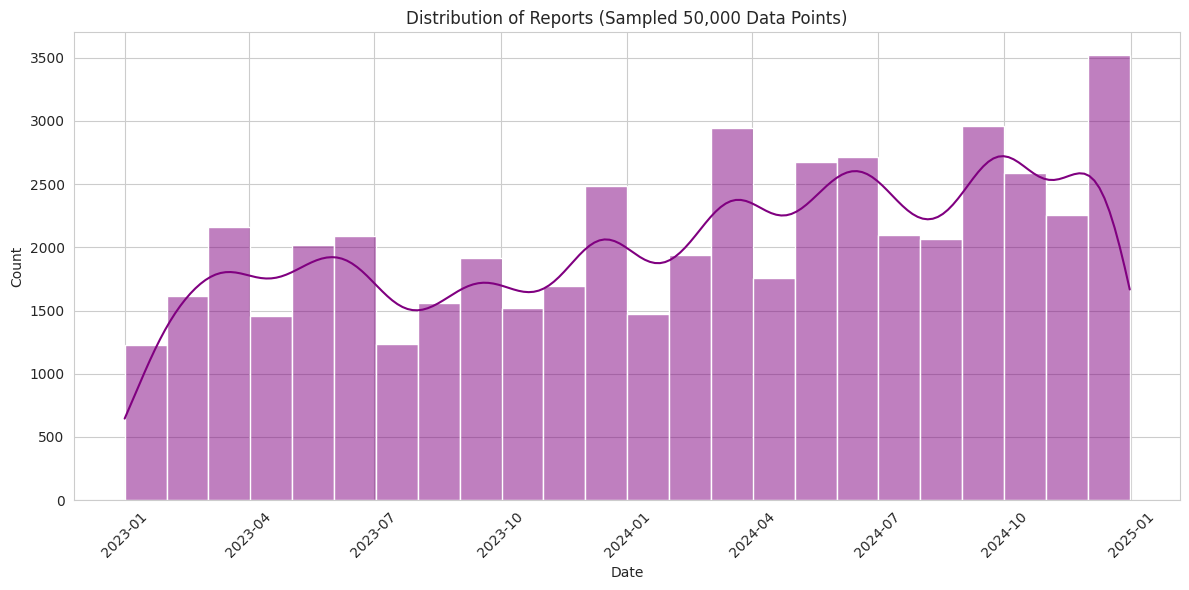

In [ ]:
df_sampled = df.sample(n=50000, random_state=42)


df_sampled['report_date'] = pd.to_datetime(df_sampled['report_date'])


plt.figure(figsize=(12, 6))
sns.histplot(df_sampled['report_date'], bins=24, kde=True, color='purple')
plt.title('Distribution of Reports (Sampled 50,000 Data Points)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


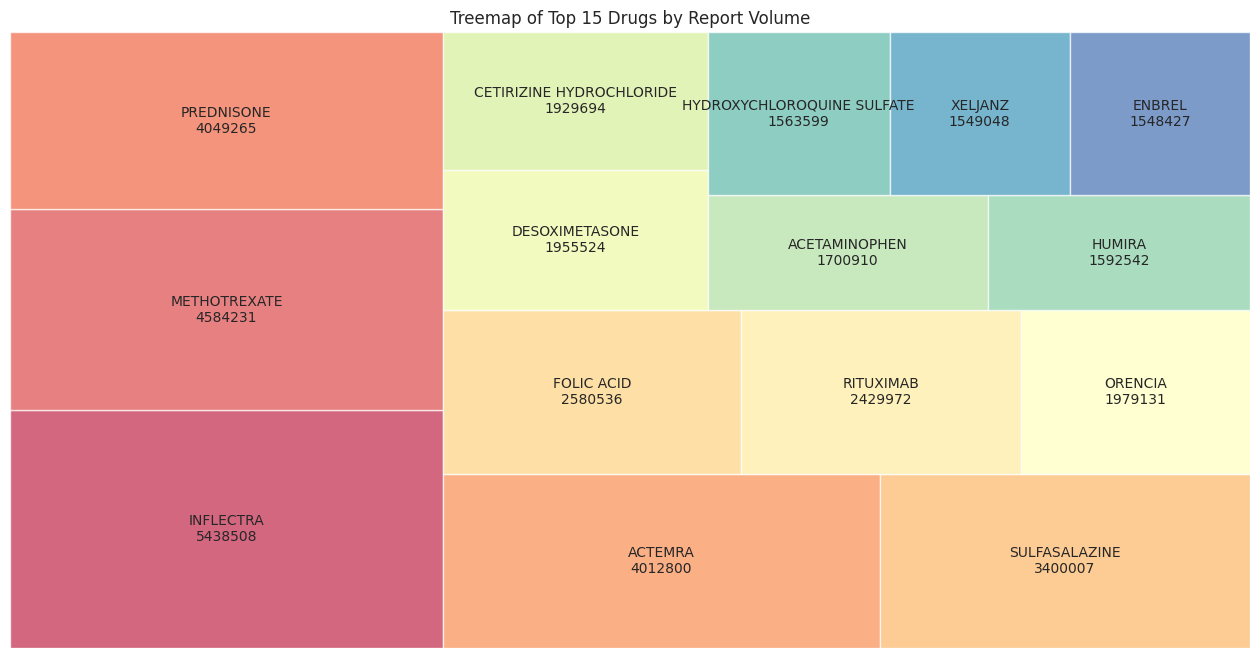

In [ ]:
plt.figure(figsize=(16, 8))
drug_counts = df['drug'].value_counts().nlargest(15)
squarify.plot(sizes=drug_counts.values,
             label=[f"{drug}\n{count}" for drug, count in zip(drug_counts.index, drug_counts.values)],
             color=sns.color_palette('Spectral', len(drug_counts)),
             alpha=0.7)
plt.title('Treemap of Top 15 Drugs by Report Volume')
plt.axis('off')
plt.show()

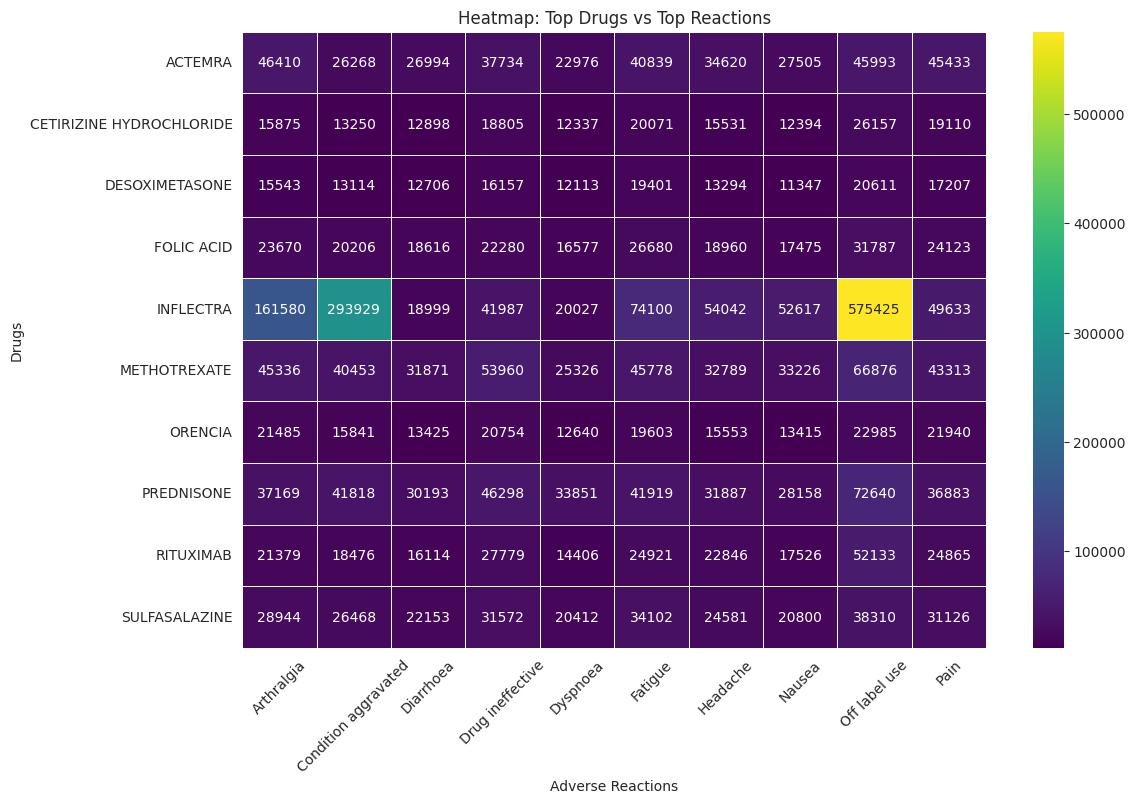

In [ ]:
top_drugs = df['drug'].value_counts().nlargest(10).index
top_reactions = df['reaction'].value_counts().nlargest(10).index
heatmap_data = pd.crosstab(df[df['drug'].isin(top_drugs)]['drug'],
                          df[df['reaction'].isin(top_reactions)]['reaction'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5)
plt.title('Heatmap: Top Drugs vs Top Reactions')
plt.xlabel('Adverse Reactions')
plt.ylabel('Drugs')
plt.xticks(rotation=45)
plt.show()

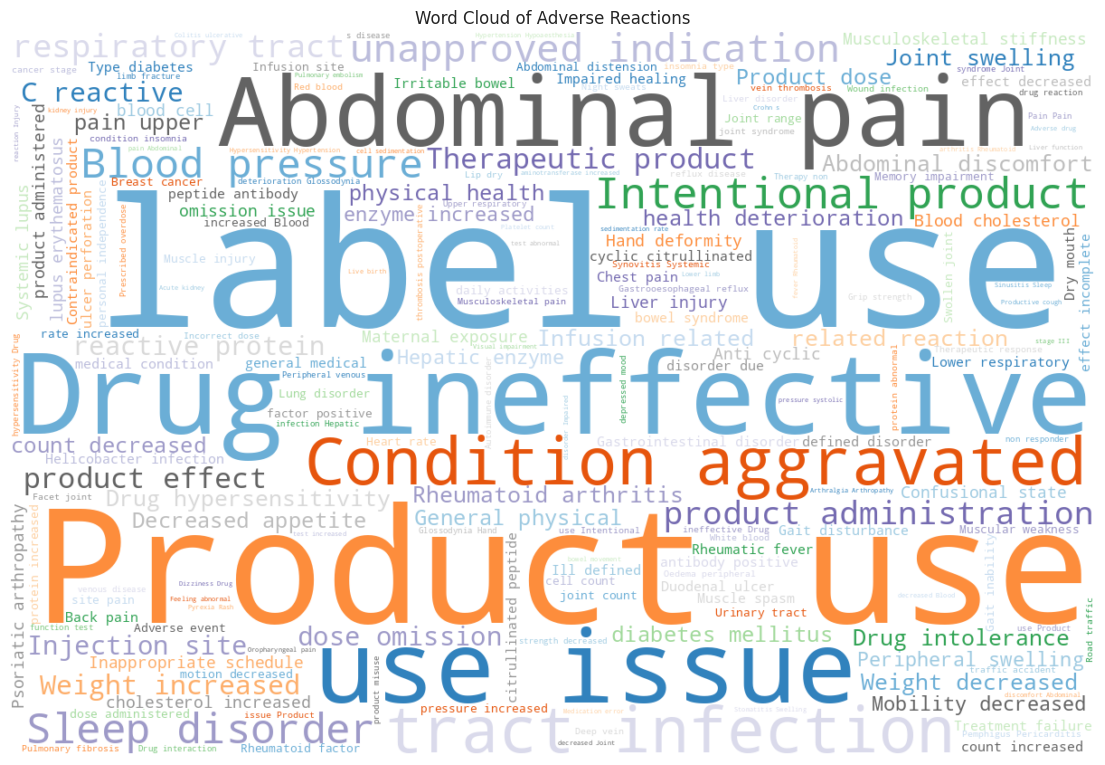

In [ ]:
reaction_text = ' '.join(df['reaction'].dropna())
wordcloud = WordCloud(width=1200, height=800,
                      background_color='white',
                      colormap='tab20c').generate(reaction_text)

plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Adverse Reactions')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Prepare data for Sankey diagram
def prepare_sankey_data(df, top_drugs=15, top_reactions=10):
    # Get top drugs and their top reactions
    top_drug_list = df['drug'].value_counts().nlargest(top_drugs).index
    filtered = df[df['drug'].isin(top_drug_list)]

    # Get top reactions for these drugs
    top_reaction_list = filtered['reaction'].value_counts().nlargest(top_reactions).index
    filtered = filtered[filtered['reaction'].isin(top_reaction_list)]

    # Create unique lists for nodes
    drugs = filtered['drug'].unique()
    reactions = filtered['reaction'].unique()
    nodes = list(drugs) + list(reactions)

    # Create source-target indices
    drug_to_id = {drug: idx for idx, drug in enumerate(drugs)}
    reaction_to_id = {reaction: idx+len(drugs) for idx, reaction in enumerate(reactions)}

    # Count connections
    connections = filtered.groupby(['drug', 'reaction']).size().reset_index(name='count')

    # Create link arrays
    sources = connections['drug'].map(drug_to_id).values
    targets = connections['reaction'].map(reaction_to_id).values
    values = connections['count'].values

    # Generate dynamic colors (semi-transparent for hover effect)
    base_colors = ["rgba(0, 128, 128, 0.3)" for _ in range(len(values))]  # Teal with transparency
    hover_colors = ["rgba(0, 128, 128, 0.8)" for _ in range(len(values))]  # Darker on hover

    return nodes, sources, targets, values, base_colors, hover_colors

nodes, sources, targets, values, base_colors, hover_colors = prepare_sankey_data(df)

# Create interactive Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="teal"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=base_colors,  # Use semi-transparent colors
        hovertemplate='%{source.label} → %{target.label}<br>Count: %{value}<extra></extra>'
    )
))

# Add customization
fig.update_layout(
    title_text="Drug-to-Reaction Flow Diagram",
    font_size=12,
    height=800,
    margin=dict(t=50, l=0, r=0, b=20),
    hovermode='x'
)

fig.show()


In [ ]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(format='png')

# Define Entities
dot.node('Report', 'Safety Report\n(safetyreport_id)', shape='box', style='filled', fillcolor='lightblue')
dot.node('Drug', 'Drug\n(drug)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('Reaction', 'Reaction\n(reaction)', shape='box', style='filled', fillcolor='lightcoral')
dot.node('Indication', 'Indication\n(indication)', shape='box', style='filled', fillcolor='lightyellow')
dot.node('Country', 'Country\n(country)', shape='box', style='filled', fillcolor='lightgrey')
dot.node('ReportDate', 'Report Date\n(report_date)', shape='box', style='filled', fillcolor='lightcyan')

# Define Relationships
dot.edge('Report', 'Drug', label='contains')
dot.edge('Drug', 'Reaction', label='causes')
dot.edge('Drug', 'Indication', label='prescribed for')
dot.edge('Report', 'Country', label='originated in')
dot.edge('Report', 'ReportDate', label='reported on')

# Render and display the diagram
dot_path = "/content/gdrive/MyDrive/faers_ner_diagram.png"
dot.render(dot_path)
dot_path


'/content/gdrive/MyDrive/faers_ner_diagram.png'

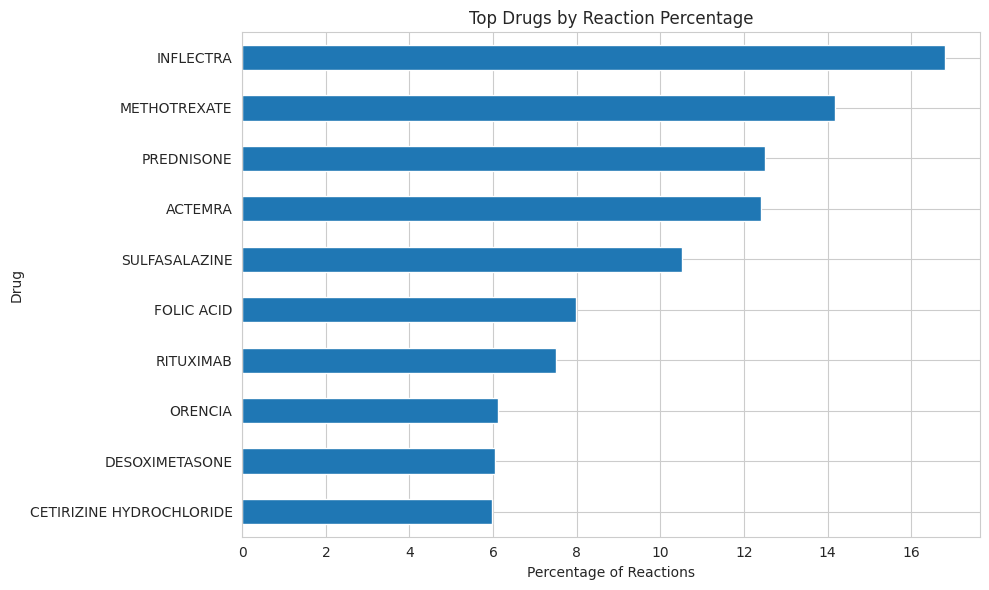

In [ ]:
reaction_counts = df['drug'].value_counts().head(10)
reaction_percent = 100 * reaction_counts / reaction_counts.sum()

# Plot
plt.figure(figsize=(10, 6))
reaction_percent.plot(kind='barh')
plt.xlabel('Percentage of Reactions')
plt.ylabel('Drug')
plt.title('Top Drugs by Reaction Percentage')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

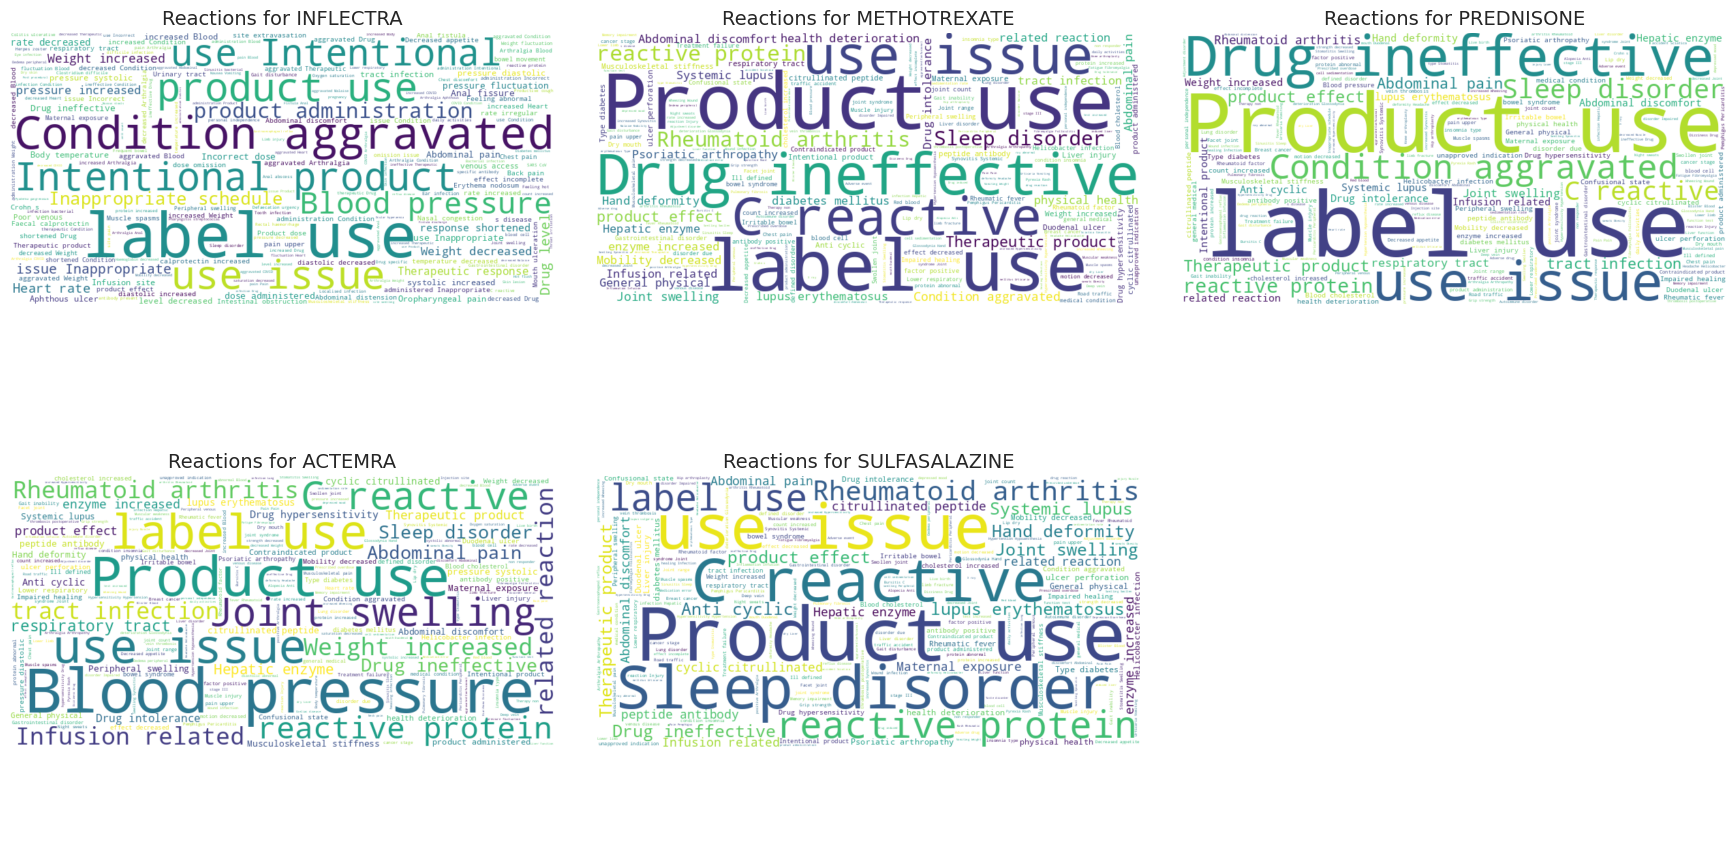

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 5 drugs
top5_drugs = df['drug'].value_counts().head(5).index


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, drug in enumerate(top5_drugs):
    reactions = df[df['drug'] == drug]['reaction'].dropna().str.cat(sep=' ')

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reactions)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Reactions for {drug}", fontsize=14)

# Hide the unused subplot (if any)
if len(top5_drugs) < len(axes):
    for j in range(len(top5_drugs), len(axes)):
        axes[j].axis('off')

# Add spacing between plots
plt.tight_layout(pad=3)
plt.show()


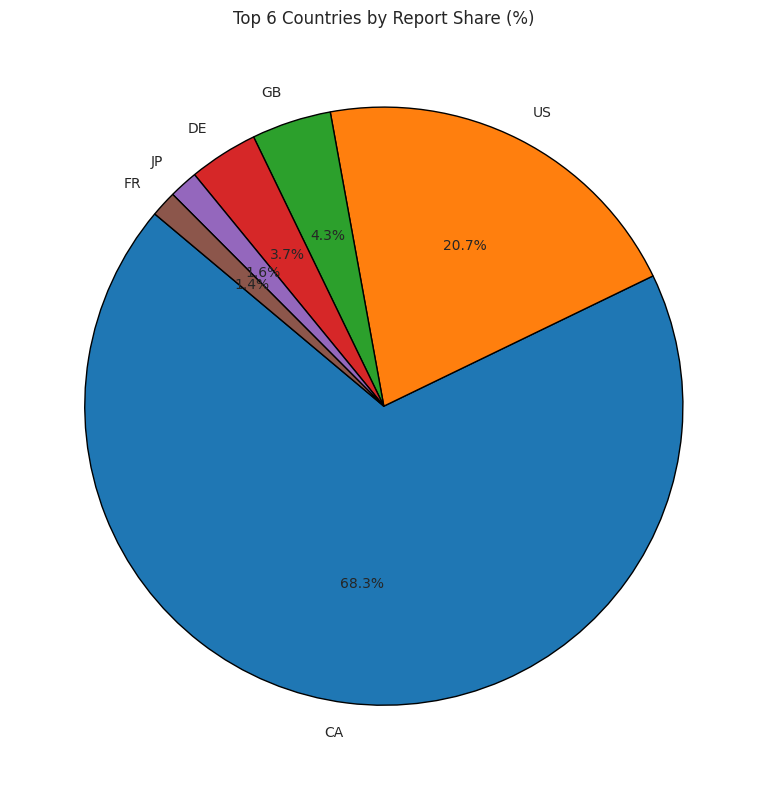

In [ ]:
top_countries = df['country'].value_counts().head(6)
plt.figure(figsize=(8, 8))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title('Top 6 Countries by Report Share (%)')
plt.tight_layout()
plt.show()


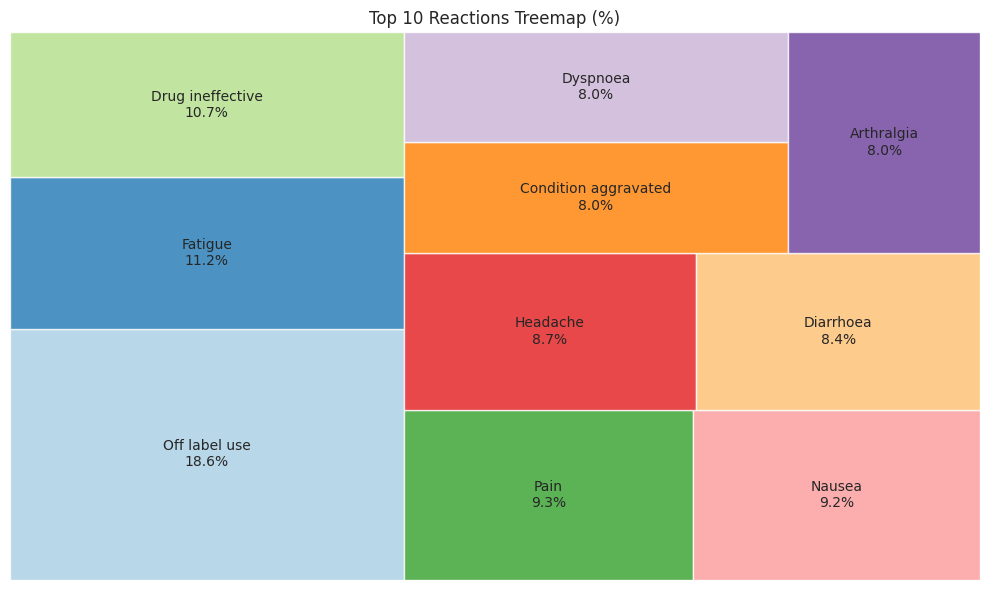

In [ ]:
import squarify

top_reactions = df['reaction'].value_counts().head(10)
sizes = top_reactions.values
labels = [f"{reaction}\n{percent:.1f}%" for reaction, percent in zip(top_reactions.index, 100 * sizes / sizes.sum())]

plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Top 10 Reactions Treemap (%)')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

subset = df.dropna(subset=['drug', 'indication', 'reaction']).head(10)  # Limit for clarity

sources = subset['drug'] + " (Drug)"
targets = subset['indication'] + " (Indication)"
values = [1] * len(subset)

df_sankey1 = pd.DataFrame({'source': sources, 'target': targets, 'value': values})
df_sankey2 = pd.DataFrame({'source': targets, 'target': subset['reaction'], 'value': values})
df_sankey = pd.concat([df_sankey1, df_sankey2])

all_nodes = list(pd.unique(df_sankey[['source', 'target']].values.ravel()))
node_map = {node: i for i, node in enumerate(all_nodes)}
df_sankey['source_id'] = df_sankey['source'].map(node_map)
df_sankey['target_id'] = df_sankey['target'].map(node_map)

fig = go.Figure(data=[go.Sankey(
    node=dict(label=all_nodes, pad=15, thickness=15),
    link=dict(source=df_sankey['source_id'], target=df_sankey['target_id'], value=df_sankey['value'])
)])
fig.update_layout(title_text="Drug → Indication → Reaction Flow", font_size=10)
fig.show()

<ipython-input-20-4aeab5d934fe>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-4aeab5d934fe>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-4aeab5d934fe>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-4aea

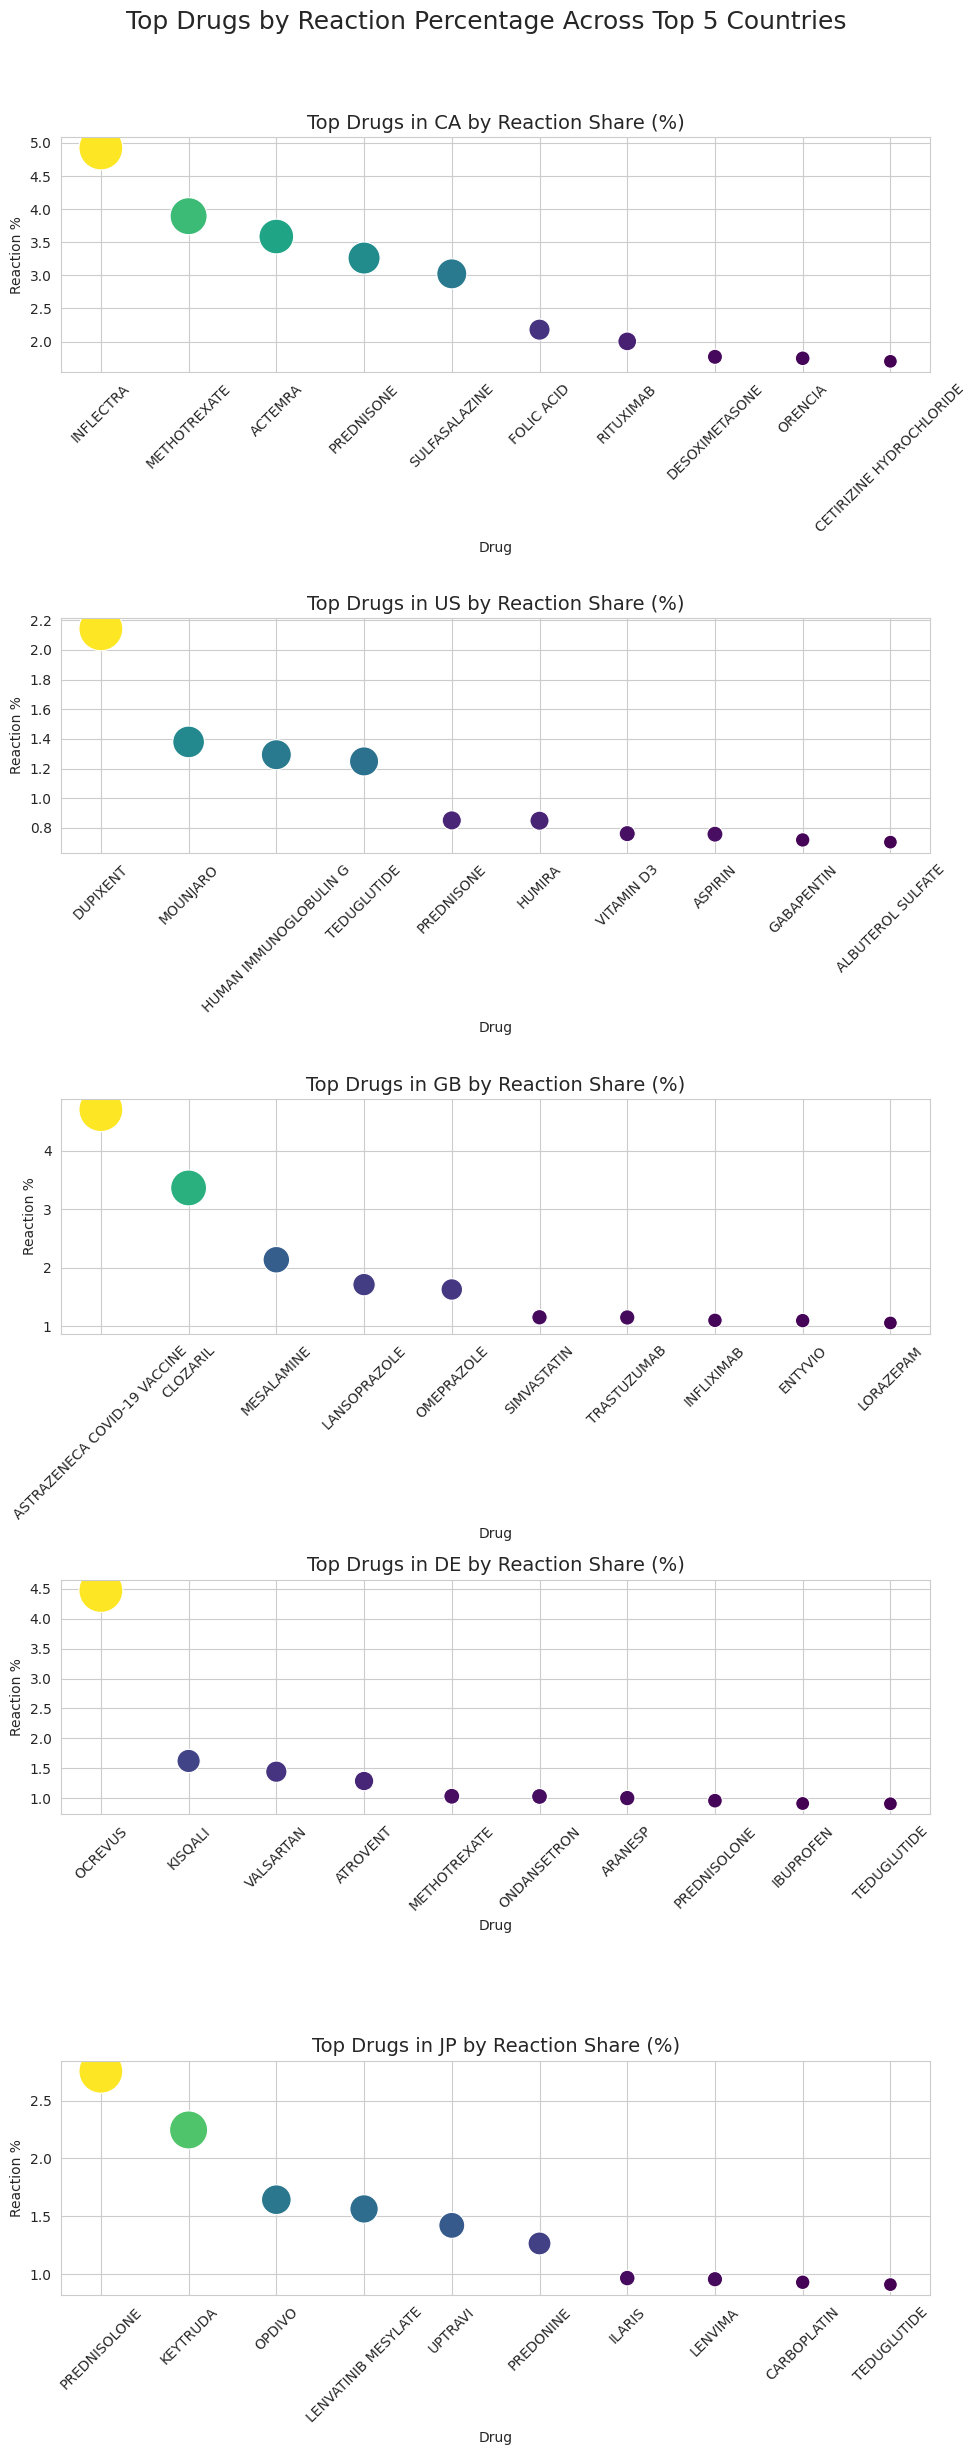

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by drug and country, and count reactions
bubble_df = df.groupby(['drug', 'country'])['reaction'].count().reset_index(name='reaction_count')

# Step 2: Get top 5 countries with most reports
top_countries = df['country'].value_counts().head(5).index

# Step 3: Create vertical subplots (5 rows x 1 column)
fig, axes = plt.subplots(5, 1, figsize=(10, 25), sharex=False)

for i, country in enumerate(top_countries):
    country_data = bubble_df[bubble_df['country'] == country]

    # Compute percent within this country
    total = country_data['reaction_count'].sum()
    country_data['reaction_percent'] = 100 * country_data['reaction_count'] / total

    # Top 10 drugs by reaction percent
    top_country_data = country_data.sort_values('reaction_percent', ascending=False).head(10)

    sns.scatterplot(
        ax=axes[i],
        data=top_country_data,
        x='drug',
        y='reaction_percent',
        size='reaction_percent',
        sizes=(100, 1000),
        hue='reaction_percent',
        palette='viridis',
        legend=False
    )

    axes[i].set_title(f"Top Drugs in {country} by Reaction Share (%)", fontsize=14)
    axes[i].set_xlabel("Drug")
    axes[i].set_ylabel("Reaction %")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Top Drugs by Reaction Percentage Across Top 5 Countries", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
